In [46]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [47]:
size=0.035
degrees = 0
path = f'rotation/Circle_{size}/data360/circle_{size}_{degrees}_degrees.csv'
simulated = pd.read_csv(path)
simulated = simulated.rename(columns={'x': 'sim_x', 'y': 'sim_y', 'z': 'sim_z'})
simulated.head()

,sim_x,sim_y,sim_z
0,0.0,0.03330,0.11940
1,0.0,0.03330,0.11962
2,0.0,0.03330,0.11983
3,0.0,0.03329,0.12005
4,0.0,0.03329,0.12027


In [48]:
traps_path = f'rotation/Circle_{size}/data360/traps_{size}_{degrees}_degrees.csv'
traps = pd.read_csv(traps_path)
traps = traps.rename(columns={'x': 'trap_x', 'y': 'trap_y', 'z': 'trap_z'})

# convert 
traps['trap_x'] = traps['trap_x'] / 1000
traps['trap_y'] = traps['trap_y'] / 1000
traps['trap_z'] = traps['trap_z'] / 1000
traps.head()

,trap_x,trap_y,trap_z
0,0.0,0.033299,0.11940
1,0.0,0.033298,0.11962
2,0.0,0.033296,0.11983
3,0.0,0.033293,0.12005
4,0.0,0.033288,0.12027


In [49]:
df = pd.concat([simulated, traps], axis=1, join='inner')
df

,sim_x,sim_y,sim_z,trap_x,trap_y,trap_z
0,0.0,0.03330,0.11940,0.0,0.033299,0.11940
1,0.0,0.03330,0.11962,0.0,0.033298,0.11962
2,0.0,0.03330,0.11983,0.0,0.033296,0.11983
3,0.0,0.03329,0.12005,0.0,0.033293,0.12005
4,0.0,0.03329,0.12027,0.0,0.033288,0.12027
...,...,...,...,...,...,...
995,0.0,0.03328,0.11832,0.0,0.033282,0.11832
996,0.0,0.03329,0.11853,0.0,0.033288,0.11853
997,0.0,0.03329,0.11875,0.0,0.033293,0.11875
998,0.0,0.03330,0.11897,0.0,0.033296,0.11897


In [115]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [116]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [117]:
wide_window = WindowGenerator(
    input_width=10, label_width=1, shift=1, label_columns=['sim_x', 'sim_y', 'sim_z'])

In [118]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [119]:
example_window = tf.stack([np.array(train_df[:wide_window.total_window_size]),
                           np.array(train_df[100:100+wide_window.total_window_size]),
                           np.array(train_df[200:200+wide_window.total_window_size])])

example_inputs, example_labels = wide_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 11, 6)
Inputs shape: (3, 10, 6)
Labels shape: (3, 1, 3)


In [120]:
wide_window.example = example_inputs, example_labels

In [121]:
BATCH_SIZE = 10
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=BATCH_SIZE,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [122]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [123]:
wide_window.train.element_spec

(TensorSpec(shape=(None, 10, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 3), dtype=tf.float32, name=None))

In [155]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (10, 1, 6)
Labels shape (batch, time, features): (10, 1, 3)


2023-06-29 10:29:35.823812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-06-29 10:29:35.824179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [700,6]
	 [[{{node Placeholder/_0}}]]


In [166]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [167]:
baseline = Baseline(label_index=column_indices['sim_y'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

20/20 [==============================] - 0s 410us/step - loss: 0.0022 - mean_absolute_error: 0.0305


2023-06-29 10:34:02.257576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [200,6]
	 [[{{node Placeholder/_0}}]]
2023-06-29 10:34:02.257920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-06-29 10:34:02.356978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [99]
	 [[{{node Placeh

In [168]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['sim_y'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['sim_y']

In [169]:
def plot(self, model=None, plot_col='sim_y', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time')

WindowGenerator.plot = plot

2023-06-29 10:34:03.314358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [676]
	 [[{{node Placeholder/_8}}]]
2023-06-29 10:34:03.314875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [676]
	 [[{{node Placeholder/_8}}]]


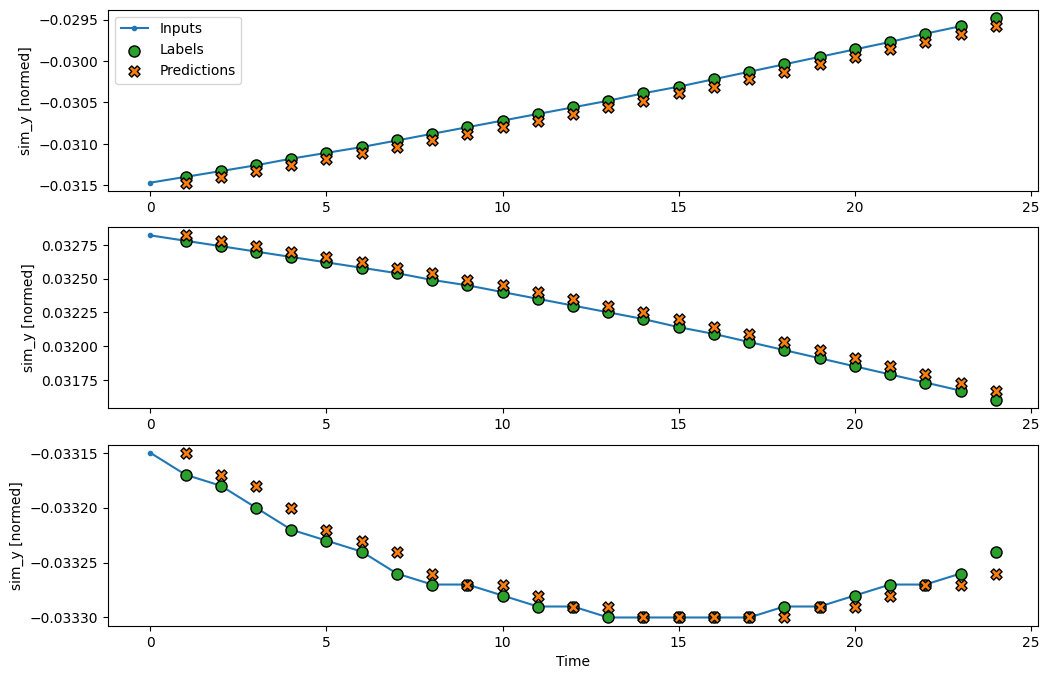

In [170]:
wide_window.plot(baseline)